# Tarea 2

In [1]:
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

## Construya la arquitectura de una red neuronal Autoencoder en PyTorch

Vamos a usar el dataset de MNIST para esta tarea. El objetivo es construir un Autoencoder que pueda aprender a comprimir y descomprimir imágenes de dígitos escritos a mano.

In [2]:
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

In [3]:
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

Vemos que las imagenes son de 28x28 píxeles y en escala de grises (1 canal).

In [4]:
# Obtenemos las dimensiones de las imágenes del dataset
train_data[0][0].shape

torch.Size([1, 28, 28])

Voy a aprovechar el mps backend de PyTorch para acelerar los entrenamientos.

In [5]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

### Simple Autoencoder

El autoencoder simple se compone de una capa de codificación y una capa de decodificación, ambas lineales. La idea es que la red aprenda a comprimir la imagen en un espacio latente y luego reconstruirla.

#### Arquitectura (Simple Autoencoder)

Las capas del encoder y decoder son lineales, y la función de activación es ReLU.

![image.png](https://tikz.net/janosh/autoencoder.png)

In [6]:
class SimpleAutoencoder(nn.Module):
    """
    Autoencoder simple para la compresión de imágenes.
    Este modelo consta de un codificador y un decodificador, ambos compuestos por capas lineales
    y funciones de activación ReLU. El codificador reduce la dimensionalidad de la entrada
    a un espacio latente de 16 dimensiones, mientras que el decodificador reconstruye
    la entrada original a partir de este espacio latente.
    Args:
        input_size (int): Tamaño de la entrada del modelo, que debe coincidir con el tamaño
                          de las imágenes aplanadas (por ejemplo, 28*28 para MNIST).
    Attributes:
        encoder (nn.Sequential): Secuencia de capas del codificador que reduce la dimensionalidad.
        decoder (nn.Sequential): Secuencia de capas del decodificador que reconstruye la entrada
                                a partir del espacio latente.
    """
    def __init__(self, input_size):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),  # Asumimos que el input esta aplanado
            nn.ReLU(),
            nn.Linear(256, 128),  
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, input_size),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### Train model (Simple Autoencoder)

In [7]:
# Inicializacion del modelo
simple_model = SimpleAutoencoder(input_size=28*28).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(simple_model.parameters(), lr=1e-3)

# Entrenamiento del modelo
epochs = 10
accum_steps = 4
counter = 0

for epoch in tqdm.tqdm(range(epochs), desc="Training Epochs"):
    accum_loss = 0.0

    optimizer.zero_grad()  # Resetear gradientes al inicio de cada epoch

    for data, _ in train_loader:
        data = data.to(device) # Utilizamos mps para acelerar el entrenamiento
        
        batch_size = data.size(0)
        data = data.view(batch_size, -1)  # El modelo espera un vector aplanado
        outputs = simple_model(data)

        loss = criterion(outputs, data) / accum_steps # For Gradient Accumulation
        loss.backward()
        accum_loss += loss.item() * batch_size # loss.item() es un promedio, multiplicamos para obtener la suma
        
        counter += 1
        if counter % accum_steps == 0: # Gradient Accumulation Step
            optimizer.step()
            optimizer.zero_grad()


    # Aplicar los gradientes restantes y resetear para el siguiente epoch
    optimizer.step()
    optimizer.zero_grad()  
    counter = 0

    # Calcular la pérdida promedio para el epoch
    avg_loss = accum_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss (MSE): {avg_loss:.4f}")


Training Epochs:  10%|█         | 1/10 [00:04<00:43,  4.88s/it]

Epoch [1/10], Loss (MSE): 0.0183


Training Epochs:  20%|██        | 2/10 [00:09<00:35,  4.49s/it]

Epoch [2/10], Loss (MSE): 0.0134


Training Epochs:  30%|███       | 3/10 [00:13<00:30,  4.36s/it]

Epoch [3/10], Loss (MSE): 0.0104


Training Epochs:  40%|████      | 4/10 [00:18<00:27,  4.66s/it]

Epoch [4/10], Loss (MSE): 0.0091


Training Epochs:  50%|█████     | 5/10 [00:22<00:22,  4.60s/it]

Epoch [5/10], Loss (MSE): 0.0085


Training Epochs:  60%|██████    | 6/10 [00:27<00:17,  4.48s/it]

Epoch [6/10], Loss (MSE): 0.0080


Training Epochs:  70%|███████   | 7/10 [00:31<00:13,  4.39s/it]

Epoch [7/10], Loss (MSE): 0.0076


Training Epochs:  80%|████████  | 8/10 [00:35<00:08,  4.32s/it]

Epoch [8/10], Loss (MSE): 0.0073


Training Epochs:  90%|█████████ | 9/10 [00:39<00:04,  4.29s/it]

Epoch [9/10], Loss (MSE): 0.0071


Training Epochs: 100%|██████████| 10/10 [00:44<00:00,  4.43s/it]

Epoch [10/10], Loss (MSE): 0.0068


#### Calcular test loss (Simple Autoencoder)

In [8]:
sum_loss = 0.0

with torch.no_grad(): # Para no calcular gradientes en el test
    for images, labels in test_loader: 
        batch_size = images.size(0)
        images = images.view(batch_size, -1) # El modelo espera un vector aplanado

        # Las imagenes deben estar en el mismo dispositivo que el modelo
        images = images.to(device) 
        outputs = simple_model(images)

        # Calculamos los loss
        loss = criterion(outputs, images)
        sum_loss += loss.item() * batch_size # loss.item() es un promedio, multiplicamos para obtener la suma

test_loss = sum_loss / len(test_loader.dataset)
print(f"Test Loss (MSE): {test_loss:.4f}")

Test Loss (MSE): 0.0270


#### Visualizar resultados (Simple Autoencoder)

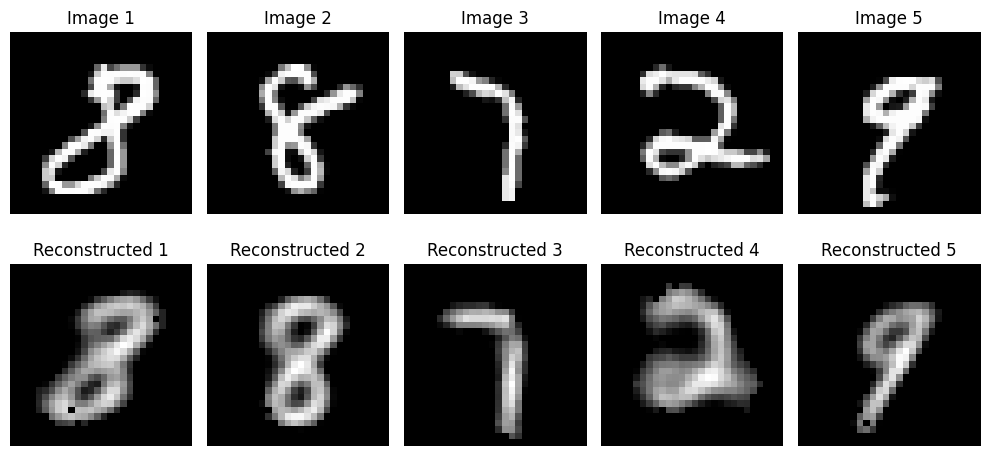

In [9]:
import random
random.seed(1234) # Para reproducibilidad

SAMPLE_SIZE = 5 # Número de imágenes a mostrar
random_indices = random.sample(range(len(test_data)), SAMPLE_SIZE)
selected_images = [test_data[i][0] for i in random_indices]

plt.figure(figsize=(10, 5)) # Tamaño de la grafica

for i, img in enumerate(selected_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.squeeze(), cmap='gray') # Mostrar imagen original
    plt.title(f"Image {i + 1}")
    plt.axis('off')

    # Computamos la predicción del modelo
    data = img.view(1, -1) # Aplanamos la imagen
    data = data.to(device)  # La imagen debe estar en el mismo dispositivo que el modelo
    pred = simple_model(data)

    # Reconstruimos la imagen a partir de la predicción
    pred = pred.view(28, 28)  # Recontruimos a la forma original
    pred = pred.detach()  # Desacoplamos de la gráfica de computación
    pred = pred.cpu()  # Movemos la predicción de vuelta a la CPU para la visualización

    plt.subplot(2, 5, i + 6)
    plt.title(f"Reconstructed {i + 1}")
    plt.imshow(pred.squeeze().numpy(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Autoencoder con CNNs

El autoencoder con CNNs utiliza capas convolucionales para codificar y decodificar las imágenes. Esto permite que la red aprenda características espaciales de las imágenes, lo cual es muy útil para datos visuales.

**Porque usar CNNs?**

Las CNNs son ideales para datos visuales porque pueden capturar patrones espaciales locales y son más eficientes en términos de parámetros. Además, las capas convolucionales pueden aprender a reconocer características jerárquicas en las imágenes, lo que mejora la capacidad de compresión y reconstrucción.

#### Arquitectura (Autoencoder con CNNs)

En este caso, las capas del encoder van a ser convolucionales y las del decoder van a ser transpuestas convolucionales.

![image.png](https://i0.wp.com/sefiks.com/wp-content/uploads/2018/03/convolutional-autoencoder.png?fit=1818%2C608&ssl=1)

In [10]:
class AutoencoderUsingCNN(nn.Module):
    """
    Autoencoder simple utilizando CNN para la compresión de imágenes.
    Este modelo consta de un codificador y un decodificador, ambos compuestos por capas
    convolucionales y funciones de activación ReLU. El codificador reduce la dimensionalidad
    de la entrada a un espacio latente de 16 dimensiones, mientras que el decodificador reconstruye
    la entrada original a partir de este espacio latente.
    Args:
        channels (int): Número de canales de la imagen de entrada (1 para imágenes en escala de grises).
        latent_dim (int): Dimensión del espacio latente al que se reduce la entrada.
    Attributes:
        encoder (nn.Sequential): Secuencia de capas del codificador que reduce la dimensionalidad.
        decoder (nn.Sequential): Secuencia de capas del decodificador que reconstruye la entrada
                                a partir del espacio latente.
    """
    def __init__(self, channels=1, latent_dim=16):
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 16, kernel_size=3, stride=2, padding=1), # -> (16, 14, 14)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), # -> (32, 7, 7)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=7),  # -> (64, 1, 1)
            nn.ReLU(),
            nn.Flatten(), # -> (64, 1, 1) -> (64)
            nn.Linear(64, latent_dim) # -> (latent_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),  # -> (64)
            nn.ReLU(),
            nn.Unflatten(1, (64, 1, 1)), # -> (64, 1, 1)
            nn.ConvTranspose2d(64, 32, kernel_size=7),  # -> (32, 7, 7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (16, 14, 14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # -> (1, 28, 28)
            nn.Sigmoid()
        )


    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### Train model (CNN Autoencoder)

In [11]:
# Inicializacion del modelo
cnn_model = AutoencoderUsingCNN(latent_dim=16).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=1e-3)

# Entrenamiento del modelo
epochs = 10
accum_steps = 4
counter = 0

for epoch in tqdm.tqdm(range(epochs), desc="Training Epochs"):
    accum_loss = 0.0

    optimizer.zero_grad()  # Resetear gradientes al inicio de cada epoch

    for data, _ in train_loader:
        batch_size = data.size(0)
        
        data = data.to(device) # Utilizamos mps para acelerar el entrenamiento
        outputs = cnn_model(data)

        loss = criterion(outputs, data) / accum_steps # For Gradient Accumulation
        loss.backward()
        accum_loss += loss.item() * batch_size # loss.item() es un promedio, multiplicamos para obtener la suma

        counter += 1
        if counter % accum_steps == 0: # Gradient Accumulation Step
            optimizer.step()
            optimizer.zero_grad()

    # Aplicar los gradientes restantes y resetear para el siguiente epoch
    optimizer.step()  
    optimizer.zero_grad()
    counter = 0 
    
    # Calcular la pérdida promedio para el epoch
    avg_loss = accum_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss (MSE): {avg_loss:.4f}")


Training Epochs:  10%|█         | 1/10 [00:06<00:55,  6.14s/it]

Epoch [1/10], Loss (MSE): 0.0199


Training Epochs:  20%|██        | 2/10 [00:11<00:46,  5.81s/it]

Epoch [2/10], Loss (MSE): 0.0123


Training Epochs:  30%|███       | 3/10 [00:17<00:40,  5.74s/it]

Epoch [3/10], Loss (MSE): 0.0069


Training Epochs:  40%|████      | 4/10 [00:23<00:34,  5.72s/it]

Epoch [4/10], Loss (MSE): 0.0053


Training Epochs:  40%|████      | 4/10 [00:24<00:37,  6.20s/it]


KeyboardInterrupt: 

#### Calcular test loss (CNN Autoencoder)

In [ ]:
sum_loss = 0.0

with torch.no_grad(): # Para no calcular gradientes en el test
    for images, labels in test_loader: 
        batch_size = images.size(0)

        # Las imagenes deben estar en el mismo dispositivo que el modelo
        images = images.to(device) 
        outputs = cnn_model(images)

        # Calculamos los loss
        loss = criterion(outputs, images)
        sum_loss += loss.item() * batch_size # loss.item() es un promedio, multiplicamos para obtener la suma

test_loss = sum_loss / len(test_loader.dataset)
print(f"Test Loss (MSE): {test_loss:.4f}")

Test Loss (MSE): 0.0121


#### Visulizar resultados (CNN Autoencoder)

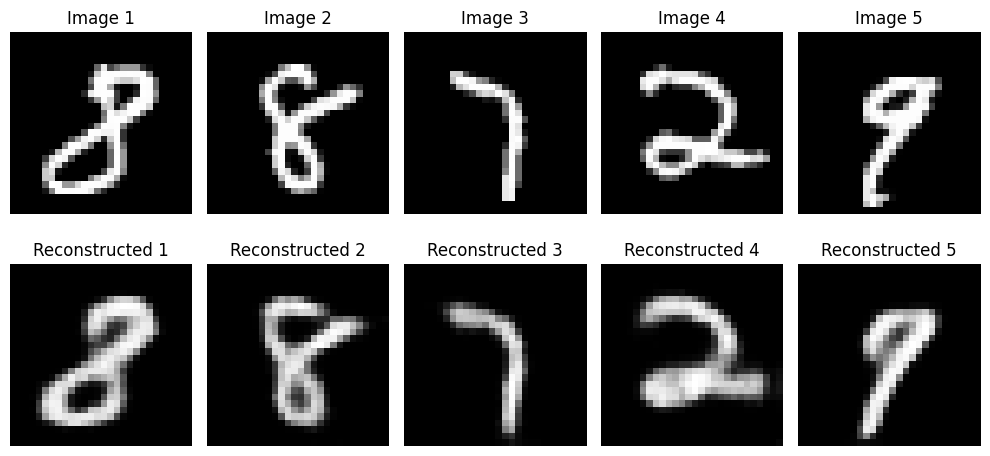

In [ ]:
import random
random.seed(1234) # Para reproducibilidad

SAMPLE_SIZE = 5 # Número de imágenes a mostrar
random_indices = random.sample(range(len(test_data)), SAMPLE_SIZE)
selected_images = [test_data[i][0] for i in random_indices]

plt.figure(figsize=(10, 5)) # Tamaño de la grafica

for i, img in enumerate(selected_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.squeeze(), cmap='gray') # Mostrar imagen original
    plt.title(f"Image {i + 1}")
    plt.axis('off')

    # Computamos la predicción del modelo
    img = img.unsqueeze(0)  # Agregamos una dimensión para el batch
    data = img.to(device)  # La imagen debe estar en el mismo dispositivo que el modelo
    pred = cnn_model(data)

    # Reconstruimos la imagen a partir de la predicción
    pred = pred.view(28, 28)  # Recontruimos a la forma original
    pred = pred.detach()  # Desacoplamos de la gráfica de computación
    pred = pred.cpu()  # Movemos la predicción de vuelta a la CPU para la visualización

    plt.subplot(2, 5, i + 6)
    plt.title(f"Reconstructed {i + 1}")
    plt.imshow(pred.squeeze().numpy(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

### Autoencoder con Vision Transformer

El autoencoder con Vision Transformer (ViT) utiliza bloques de Transformer para codificar y decodificar las imágenes. Esto permite que la red aprenda relaciones globales entre diferentes partes de la imagen, lo cual es útil para datos complejos.

**Porque usar Vision Transformer?**

Los Vision Transformers son adecuados para tareas que requieren una comprensión global de la imagen, ya que pueden capturar relaciones entre diferentes regiones de la imagen. Son especialmente útiles para datasets grandes y complejos, donde las relaciones espaciales son importantes.

#### Arquitectura (ViT Autoencoder)

La arquitectura se puede simplificar en el siguiente diagrama:

![Diagram](Flowchart.png)

Donde se tiene que 

- **Patch Embedding**: Convierte la imagen en parches y los proyecta a un espacio de características.
- **Positional Embedding**: Añade información posicional a los parches para que el modelo pueda entender la disposición espacial.
- **Transformer Encoder**: Bloques de Transformer que procesan los parches y aprenden relaciones globales.
- **Decoder**: Capa lineal que reconstruye la imagen a partir de las características aprendidas.


In [ ]:
# Patch Embedding: convierte imagen (1, 28, 28) en patches (tokens)
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=28, patch_size=7, in_channels=1, embed_dim=64):
        super().__init__()
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x shape: (B, C, H, W)
        x = self.proj(x)  # (B, embed_dim, H/patch, W/patch)
        x = x.flatten(2)  # (B, embed_dim, N)
        x = x.transpose(1, 2)  # (B, N, embed_dim)
        return x

# Autoencoder con ViT
class ViTAutoencoder(nn.Module):
    def __init__(self, img_size=28, patch_size=7, embed_dim=64, num_heads=4, depth=2):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, 1, embed_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.randn(1, (img_size // patch_size)**2 + 1, embed_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        self.decoder = nn.Sequential(
            nn.Linear(embed_dim, patch_size * patch_size),
        )
        self.patch_size = patch_size
        self.img_size = img_size

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)  # (B, N, D)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)
        x = x + self.pos_embed

        x = self.transformer(x)[:, 1:]  # Ignorar cls_token
        x = self.decoder(x)  # (B, N, patch_size*patch_size)
        x = x.view(B, 1, self.img_size, self.img_size)  # Reconstrucción imagen completa
        return x

#### Train model (ViT Autoencoder)

In [ ]:
vit_model = ViTAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(vit_model.parameters(), lr=1e-3)

accum_steps = 4
counter = 0

for epoch in tqdm.tqdm(range(epochs), desc="Training Epochs"):
    accum_loss = 0.0

    optimizer.zero_grad()  # Resetear gradientes al inicio de cada epoch

    for data, _ in train_loader:
        batch_size = data.size(0)
        
        data = data.to(device) # Utilizamos mps para acelerar el entrenamiento
        outputs = vit_model(data)

        loss = criterion(outputs, data) / accum_steps # For Gradient Accumulation
        loss.backward()
        accum_loss += loss.item() * batch_size # loss.item() es un promedio, multiplicamos para obtener la suma

        counter += 1
        if counter % accum_steps == 0: # Gradient Accumulation Step
            optimizer.step()
            optimizer.zero_grad()

    # Aplicar los gradientes restantes y resetear para el siguiente epoch
    optimizer.step()  
    optimizer.zero_grad()
    counter = 0 
    
    # Calcular la pérdida promedio para el epoch
    avg_loss = accum_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss (MSE): {avg_loss:.4f}")

Training Epochs:  10%|█         | 1/10 [00:10<01:36, 10.73s/it]

Epoch [1/10], Loss (MSE): 0.0166


Training Epochs:  20%|██        | 2/10 [00:20<01:22, 10.32s/it]

Epoch [2/10], Loss (MSE): 0.0060


Training Epochs:  30%|███       | 3/10 [00:30<01:11, 10.25s/it]

Epoch [3/10], Loss (MSE): 0.0037


Training Epochs:  40%|████      | 4/10 [00:41<01:01, 10.28s/it]

Epoch [4/10], Loss (MSE): 0.0028


Training Epochs:  50%|█████     | 5/10 [00:51<00:51, 10.35s/it]

Epoch [5/10], Loss (MSE): 0.0023


Training Epochs:  60%|██████    | 6/10 [01:01<00:40, 10.19s/it]

Epoch [6/10], Loss (MSE): 0.0019


Training Epochs:  70%|███████   | 7/10 [01:11<00:30, 10.12s/it]

Epoch [7/10], Loss (MSE): 0.0017


Training Epochs:  80%|████████  | 8/10 [01:21<00:20, 10.12s/it]

Epoch [8/10], Loss (MSE): 0.0015


Training Epochs:  90%|█████████ | 9/10 [01:31<00:10, 10.07s/it]

Epoch [9/10], Loss (MSE): 0.0014


Training Epochs: 100%|██████████| 10/10 [01:41<00:00, 10.14s/it]

Epoch [10/10], Loss (MSE): 0.0013


#### Calcular test loss (ViT Autoencoder)

In [ ]:
sum_loss = 0.0

with torch.no_grad(): # Para no calcular gradientes en el test
    for images, labels in test_loader: 
        batch_size = images.size(0)

        # Las imagenes deben estar en el mismo dispositivo que el modelo
        images = images.to(device) 
        outputs = vit_model(images)

        # Calculamos los loss
        loss = criterion(outputs, images)
        sum_loss += loss.item() * batch_size # loss.item() es un promedio, multiplicamos para obtener la suma

test_loss = sum_loss / len(test_loader.dataset)
print(f"Test Loss (MSE): {test_loss:.4f}")

Test Loss (MSE): 0.0049


#### Visualizar resultados (ViT Autoencoder)

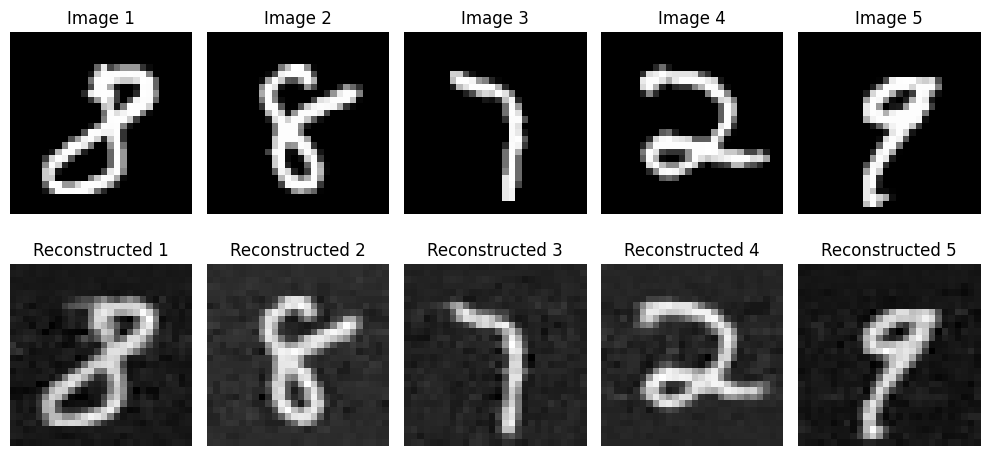

In [ ]:
import random
random.seed(1234) # Para reproducibilidad

SAMPLE_SIZE = 5 # Número de imágenes a mostrar
random_indices = random.sample(range(len(test_data)), SAMPLE_SIZE)
selected_images = [test_data[i][0] for i in random_indices]

plt.figure(figsize=(10, 5)) # Tamaño de la grafica

for i, img in enumerate(selected_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.squeeze(), cmap='gray') # Mostrar imagen original
    plt.title(f"Image {i + 1}")
    plt.axis('off')

    # Computamos la predicción del modelo
    img = img.unsqueeze(0)  # Agregamos una dimensión para el batch
    data = img.to(device)  # La imagen debe estar en el mismo dispositivo que el modelo
    pred = vit_model(data)

    # Reconstruimos la imagen a partir de la predicción
    pred = pred.view(28, 28)  # Recontruimos a la forma original
    pred = pred.detach()  # Desacoplamos de la gráfica de computación
    pred = pred.cpu()  # Movemos la predicción de vuelta a la CPU para la visualización

    plt.subplot(2, 5, i + 6)
    plt.title(f"Reconstructed {i + 1}")
    plt.imshow(pred.squeeze().numpy(), cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

## Que diferencia hay entre las arquitecturas de Autoencoders?

En general, los vision transformers son más adecuados para tareas que requieren una comprensión global de la imagen, mientras que las CNNs son más eficientes para tareas locales. Los autoencoders simples son útiles para datos tabulares o 1D, pero no escalan bien con imágenes grandes.

**Tabla Comparativa de arquitecturas de Autoencoders**

| Característica                             | Simple (Capas Lineales)                   | Convolucionales (CNN)                     | Vision Transformer (ViT)                           |
|-------------------------------------------|-----------------------------------------|-------------------------------------------|----------------------------------------------------|
| **Representación espacial**               | No conserva información espacial         | Conserva relaciones locales               | Aprende relaciones globales entre parches         |
| **Parámetros**                            | Muchos parámetros, sin compartir pesos  | Menos parámetros, pesos compartidos       | Alto número de parámetros, pero eficiente en escala |
| **Localidad**                             | No aprovecha estructuras locales         | Excelente para detectar patrones locales  | Puede capturar tanto relaciones locales como globales |
| **Robustez a traslaciones**               | Baja                                     | Alta (gracias a convoluciones y pooling)  | Requiere aprendizaje explícito de relaciones espaciales |
| **Desempeño en imágenes simples (MNIST)** | Aceptable, pero subóptimo               | Muy bueno, rápido de entrenar             | Bueno, pero podría ser excesivo para datos simples |
| **Desempeño en imágenes complejas**       | Deficiente                               | Bueno, aunque puede perder relaciones globales | Muy bueno, especialmente en datasets grandes       |
| **Coste computacional**                   | Bajo                                     | Medio                                      | Alto (requiere mayor memoria y cómputo)           |
| **Dificultad de implementación**          | Fácil                                | Moderada                                  | Alta, requiere mayor conocimiento y estructura     |
| **Aplicación en autoencoders**            | Básico, útil para tabulares o 1D         | Muy efectivo para compresión y reconstrucción de imágenes | Ideal para modelar dependencias espaciales complejas |
| **Ventaja principal**                     | Simplicidad                              | Buena compresión espacial con bajo coste  | Aprendizaje de relaciones globales y flexibilidad |
| **Desventaja principal**                  | No escala bien con imágenes grandes      | Limitado a contexto local                 | Requiere más datos y cómputo                      |
